# Import modules

In [ ]:
import numpy as np
import pandas as pd

import os
import cv2
import glob
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

# Loading Inference (json)

In [ ]:
train_meta = []

json_obj = json.load(open('/content/drive/Shareddrives/해커톤/ysm/big_image_final_250000.json'))
# json_obj['features']
for f in json_obj['features']:
    object_imcoords = f['properties']['object_imcoords']
    image_id = f['properties']['image_id'] 
    type_id = f['properties']['type_id'] 
    type_name = f['properties']['type_name'] 
    scores = f['properties']['scores'] 
    area = f['properties']['area'] 

    # add to list
    train_meta.append([image_id, scores, type_id, type_name, object_imcoords, area])

# Make dataframe
df_inf = pd.DataFrame(train_meta,
                      columns = ['image_id','scores','type_id','type_name', 'object_imcoords', 'area'])

df_inf

,image_id,scores,type_id,type_name,object_imcoords,area
0,0_4.png,0.951866,2,large ship,"827.8235,893.7976,871.24646,988.424",4108.959961
1,0_4.png,0.890887,5,small car,"867.6325,724.45966,879.95374,732.48",98.820251
2,0_4.png,0.889924,5,small car,"866.5242,718.78986,879.60406,726.8065",104.857101
3,0_4.png,0.878649,5,small car,"868.5078,735.55707,879.90717,743.49133",90.445488
4,0_4.png,0.872207,5,small car,"690.1762,226.78265,702.56683,236.57613",121.347244
...,...,...,...,...,...,...
5434,10_11.png,0.517249,5,small car,"232.34818,908.46063,241.60045,917.9866",88.136604
5435,10_11.png,0.511205,5,small car,"300.8182,833.9809,308.11948,844.52014",76.949875
5436,10_11.png,0.505567,5,small car,"948.25543,978.78784,958.5015,993.9105",154.948410
5437,10_11.png,0.504508,5,small car,"608.46466,939.026,619.6324,946.87665",87.673866


In [ ]:
df_object = df_inf.type_name.value_counts().to_frame(name = 'obj_count')
df_object

,obj_count
small car,4860
grouped container,139
individual container,133
truck,99
small ship,58
bus,53
swimming pool,52
oil tank,18
train,13
large ship,12


In [ ]:
df_temp = df_inf.loc[:,['type_name','type_id']].copy()
df_temp = df_temp.drop_duplicates(ignore_index=True)
df_temp = df_temp.set_index('type_name')
df_temp

,type_id
type_name,
large ship,2
small car,5
small ship,1
oil tank,11
individual container,18
grouped container,19
swimming pool,20
bus,6
truck,7


In [ ]:
df_object = df_object.join(df_temp)
df_object

,obj_count,type_id
small car,4860,5
grouped container,139,19
individual container,133,18
truck,99,7
small ship,58,1
bus,53,6
swimming pool,52,20
oil tank,18,11
train,13,8
large ship,12,2


In [ ]:
s_temp = df_inf.groupby(['type_name'])['scores'].sum()/df_inf.groupby(['type_name'])['scores'].nunique()
s_temp.name = 'avg_scores'
s_temp

type_name
bus                     0.654923
grouped container       0.633499
individual container    0.603249
large ship              0.828695
oil tank                0.855100
outdoor playground      0.962393
roundabout              0.973292
small car               0.696339
small ship              0.629447
swimming pool           0.615366
train                   0.583675
truck                   0.601692
Name: avg_scores, dtype: float64

In [ ]:
df_object = pd.concat([df_object,s_temp], axis=1)
df_object

,obj_count,type_id,avg_scores
small car,4860,5,0.696339
grouped container,139,19,0.633499
individual container,133,18,0.603249
truck,99,7,0.601692
small ship,58,1,0.629447
bus,53,6,0.654923
swimming pool,52,20,0.615366
oil tank,18,11,0.855100
train,13,8,0.583675
large ship,12,2,0.828695


In [ ]:
s_temp = df_inf.groupby(['type_name'])['area'].sum()/df_inf.groupby(['type_name'])['area'].nunique()
s_temp.name = 'avg_area'
s_temp

type_name
bus                       274.010773
grouped container         595.377786
individual container      213.805902
large ship              18117.029439
oil tank                 2128.689290
outdoor playground      83199.226562
roundabout              12499.003906
small car                  98.295719
small ship                312.027365
swimming pool             230.042380
train                     497.156349
truck                     267.336406
Name: avg_area, dtype: float64

In [ ]:
df_object = pd.concat([df_object,s_temp], axis=1)
df_object

,obj_count,type_id,avg_scores,avg_area
small car,4860,5,0.696339,98.295719
grouped container,139,19,0.633499,595.377786
individual container,133,18,0.603249,213.805902
truck,99,7,0.601692,267.336406
small ship,58,1,0.629447,312.027365
bus,53,6,0.654923,274.010773
swimming pool,52,20,0.615366,230.042380
oil tank,18,11,0.855100,2128.689290
train,13,8,0.583675,497.156349
large ship,12,2,0.828695,18117.029439


In [ ]:
df_object = df_object[['type_id', 'avg_scores','avg_area','obj_count']].sort_values('avg_scores',ascending = False)
df_object

,type_id,avg_scores,avg_area,obj_count
roundabout,16,0.973292,12499.003906,1
outdoor playground,14,0.962393,83199.226562,1
oil tank,11,0.855100,2128.689290,18
large ship,2,0.828695,18117.029439,12
small car,5,0.696339,98.295719,4860
bus,6,0.654923,274.010773,53
grouped container,19,0.633499,595.377786,139
small ship,1,0.629447,312.027365,58
swimming pool,20,0.615366,230.042380,52
individual container,18,0.603249,213.805902,133


In [ ]:
import seaborn as sns

object_corr=df_object.corr()
object_corr
#df_heatmap = sns.heatmap(object_corr, vmin = -1, vmax = 1, cbar = True, fmt = '.2f', cmap = 'PiYG')

,avg_scores,avg_area,obj_count
avg_scores,1.000000,0.668458,-0.074552
avg_area,0.668458,1.000000,-0.144714
obj_count,-0.074552,-0.144714,1.000000


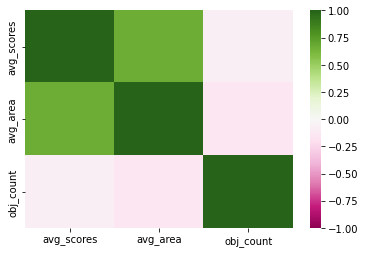

In [ ]:
sns.heatmap(object_corr, vmin = -1, vmax = 1, cbar = True, fmt = '.2f', cmap = 'PiYG')

avg_scores 와 avg_area 사이의 상관계수가 큼
그런데도 small car가 다른 것보다 잘 잡히는 건 object 수가 많아서???

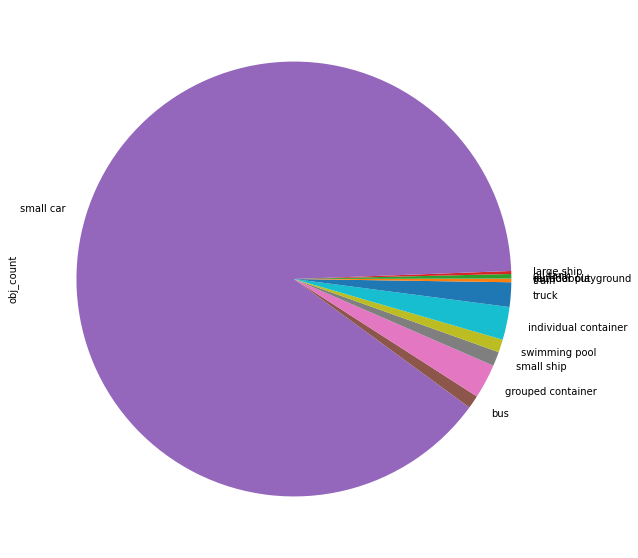

In [ ]:
plt.figure(figsize=(10,10))
df_object['obj_count'].plot.pie()